### Test shift in predictions & accuracy in population model
- For each bird, we create a dataset of n_trials * n_neurons, where trials are the total number of spikes during that trial
- we train a 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# set to be lower priority
#os.nice(1) 

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas  as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', 500)
from joblib import Parallel, delayed

In [5]:
from cdcp.spiketrain_analysis.spiketrain_utils import (
    bin_interp_points,
)

In [6]:
from datetime import datetime

In [7]:
from cdcp.spiketrain_analysis.spiketrain_utils import (
    get_spike_train_vector
)

In [8]:
from cdcp.spiketrain_analysis.unit_stats.cued_similarity_and_spikevector_differences import (
    compute_cued_average_sm_rv_differences
)

In [9]:
# "2021-10-07_16-05-58_796914" '2021-10-06_13-30-08_899062' '2021-10-01_17-02-56_744915' 
statistics_timestamp = '2021-10-23_23-02-31_846685'# datetime.now().strftime("%Y-%m-%d_%H-%M-%S_%f")#
statistics_timestamp

'2021-10-23_23-02-31_846685'

In [10]:
birds = [
    #('B1188', '2021-05-31_18-52-29_558216', 'kilosort2_5'),
    ('B1597', '2021-05-14_12-40-20_423998', 'kilosort2_5'),
    ('B1595', '2021-07-10_16-42-47_090257', 'kilosort2'),
    #('B1276', '2021-07-14_11-14-02_257025', 'kilosort2'),
    ('B1426', '2021-07-14_11-29-39_657273', 'kilosort2'),
    ('B1432', '2021-06-01_15-14-38_561892', 'kilosort2_5'),
    ('B1170', '2021-06-01_21-01-26_519005', 'kilosort2_5'),
    ('B1244', '2021-07-14_12-57-45_546674', 'kilosort2'),
    ('B1593', '2021-06-28_18-13-24_826008', 'kilosort2_5'),
    ('B1248', '2021-07-03_18-08-01_063431', 'kilosort2_5'),
    # acute
    #('B1279', '2021-04-12_16-27-07_289527', 'kilosort2_5'),
    #('B1500', '2021-08-27_09-24-48_680961', 'kilosort2_5'),
    #('B1239', '2021-05-17_22-18-51_557635', 'kilosort2'),
    #('B1459', '2021-08-26_21-21-12_755614', 'kilosort2_5'),
]

In [11]:
from sklearn.decomposition import PCA
#from umap import UMAP
from sklearn import linear_model
from sklearn.metrics import confusion_matrix

In [12]:
def train_test_split_trials(trial_df_interp):
    trial_df_interp["data_category"] = "training"
    
    trial_df_interp.loc[trial_df_interp.cue.isin(['CN', 'NC']), 'data_category'] = "uncued/passive"
    trial_df_interp.loc[trial_df_interp.passive == True, 'data_category'] = "uncued/passive"

    # grab held out cue invalid trials
    held_out_cue_invalid_trials = trial_df_interp[
        (trial_df_interp.cue_valid == False) &
        (trial_df_interp.data_category != "uncued/passive")
    ].index
    trial_df_interp.loc[
        held_out_cue_invalid_trials, "data_category"
    ] = "held_out_invalid"
    
    # ensure that there are data for each inter bin in held out cue invalid trials
    if (
        len(
            np.unique(
                trial_df_interp.loc[held_out_cue_invalid_trials][
                    "interp_point_binned"
                ]
            )
        )
        != 16
    ):
        print('Skipping for not enough invalid trials (cue invalid)')
        return
    
    skip_for_data_requirements = False
    # create matched held out training data
    for interp_bin in np.unique(
        trial_df_interp.loc[held_out_cue_invalid_trials]["interp_point_binned"]
    ):
        n_to_sample = np.sum(
            trial_df_interp.loc[held_out_cue_invalid_trials]["interp_point_binned"]
            == interp_bin
        )
    
        cue_valid_to_sample_from = trial_df_interp[
            (trial_df_interp["cue_valid"] == True)
            & (trial_df_interp["interp_point_binned"] == interp_bin)
        ].index
        # skip this interpolation if there isn't sufficient cue valid data
        if len(cue_valid_to_sample_from) < (n_to_sample + 1):
            skip_for_data_requirements = True
            break
    
        trial_df_interp.loc[
            np.random.permutation(cue_valid_to_sample_from)[:n_to_sample],
            "data_category",
        ] = "held_out_valid"
    if skip_for_data_requirements:
        
        print('Skipping for not enough invalid trials (cue valid)')
        return
    return trial_df_interp

In [13]:
plot_umap = False
plot_PCs = True
plot_confusion_matrix = True

  0%|          | 0/8 [00:00<?, ?it/s]

B1597
B1597 AF 19452


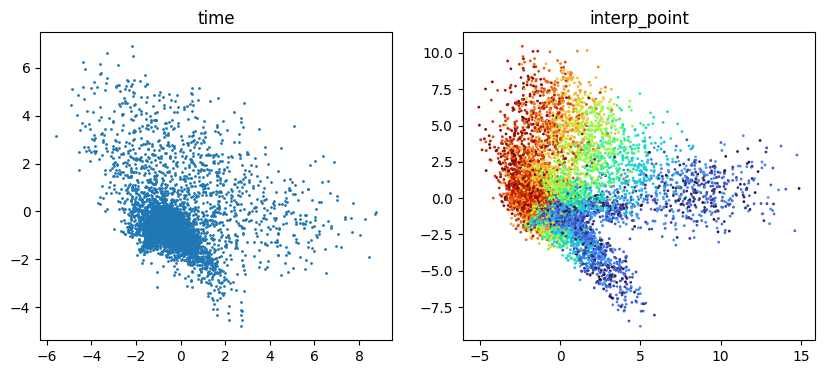

train acc: 0.548 | valid acc: 0.281 | invalid acc: 0.273


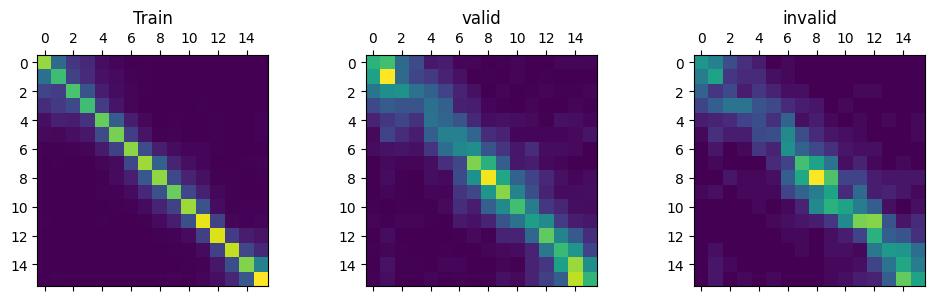

B1597 BE 19526


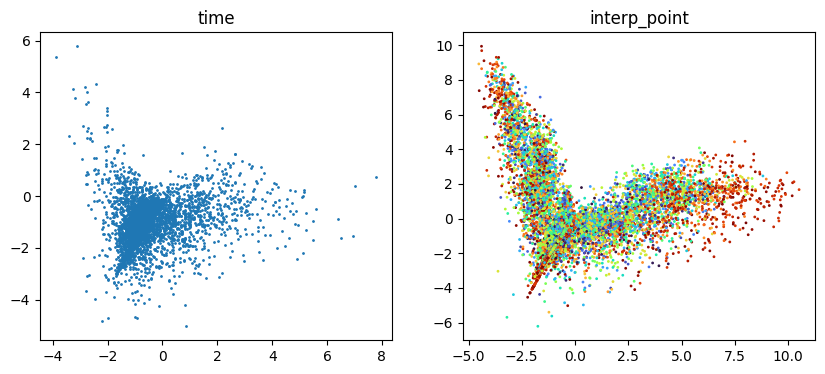

train acc: 0.4 | valid acc: 0.183 | invalid acc: 0.164


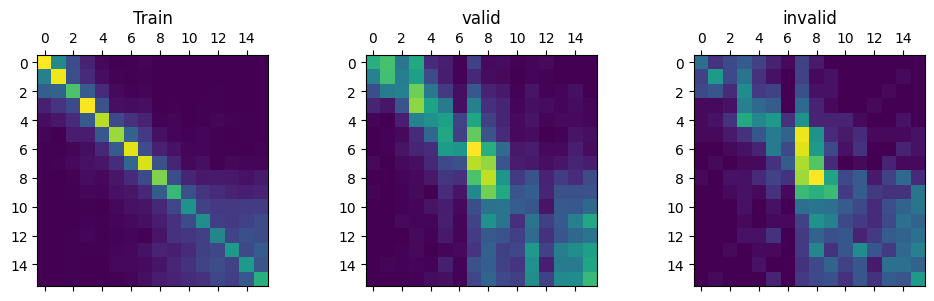

B1597 AE 46523


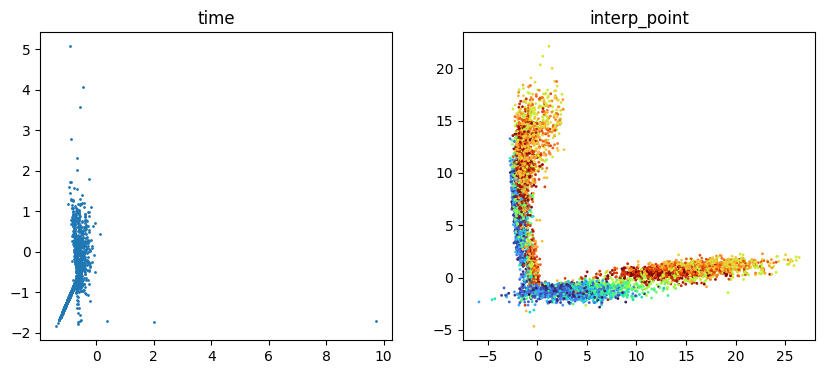

train acc: 0.522 | valid acc: 0.347 | invalid acc: 0.289


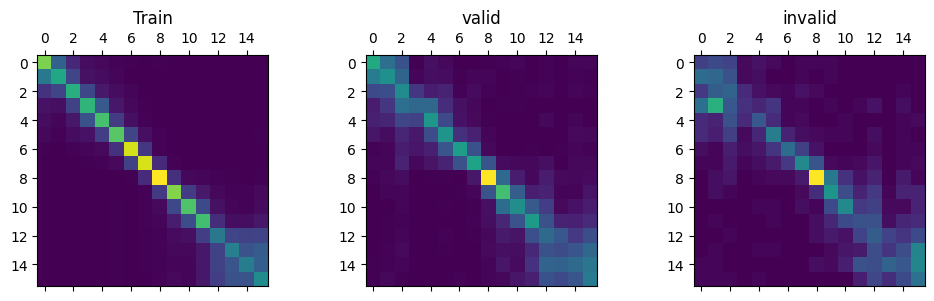

B1597 BF 39617


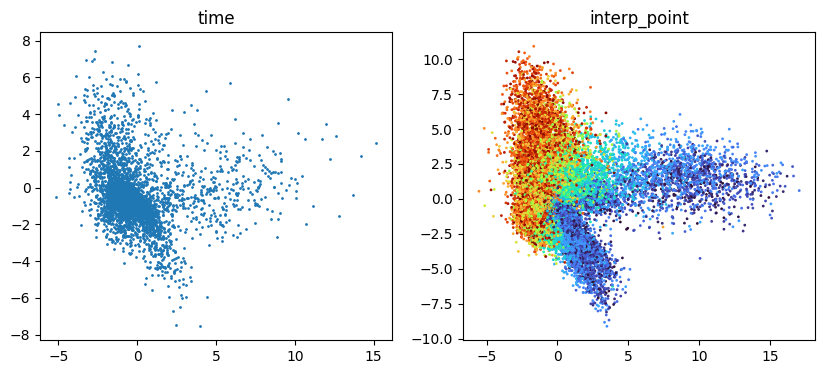

train acc: 0.488 | valid acc: 0.347 | invalid acc: 0.326


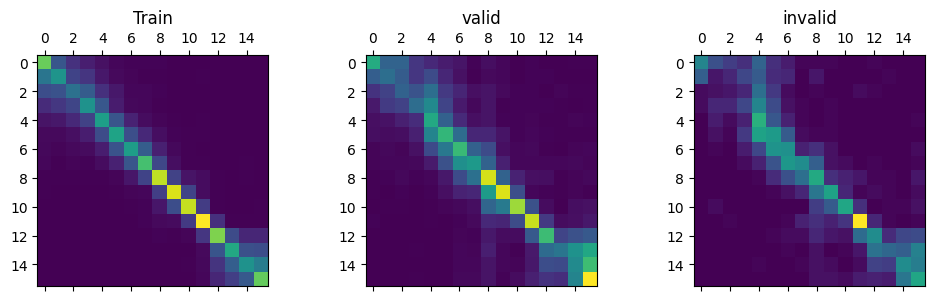

B1597 CG 11268


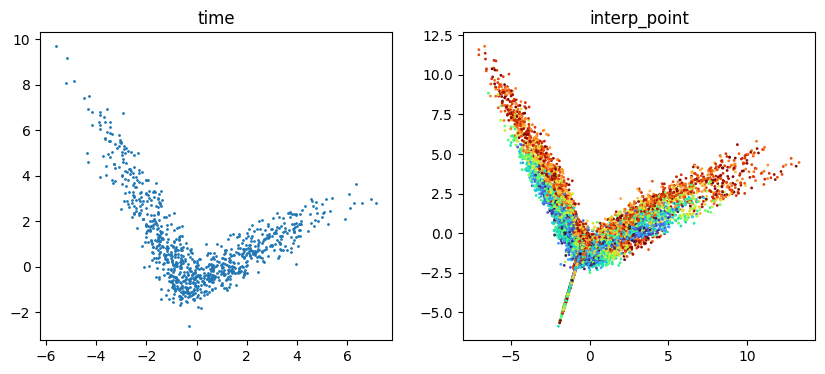

train acc: 0.481 | valid acc: 0.285 | invalid acc: 0.328


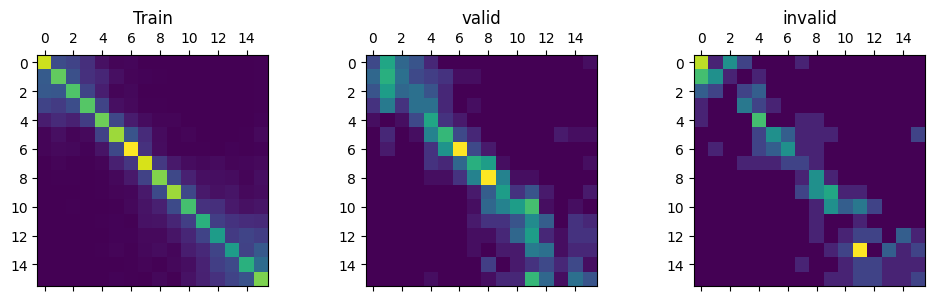

B1597 CE 11320
Skipping for not enough invalid trials (cue valid)
B1597 AG 11401


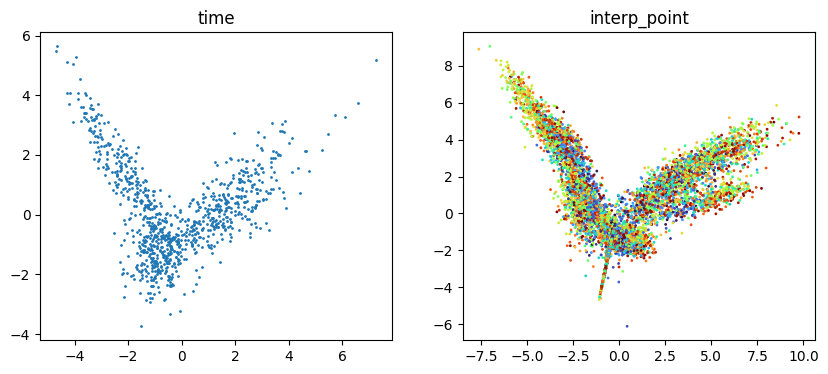

train acc: 0.5 | valid acc: 0.391 | invalid acc: 0.304


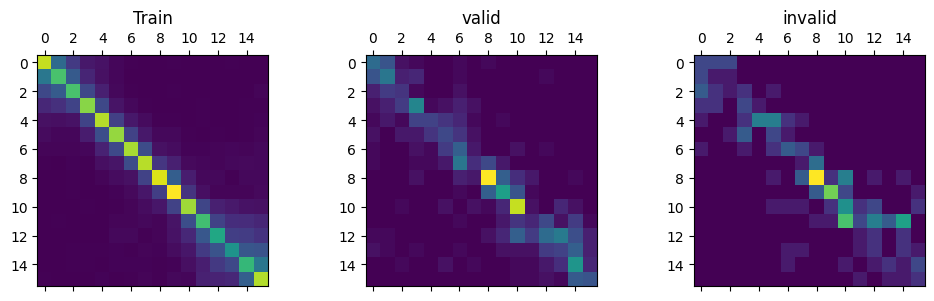

B1597 CF 17478


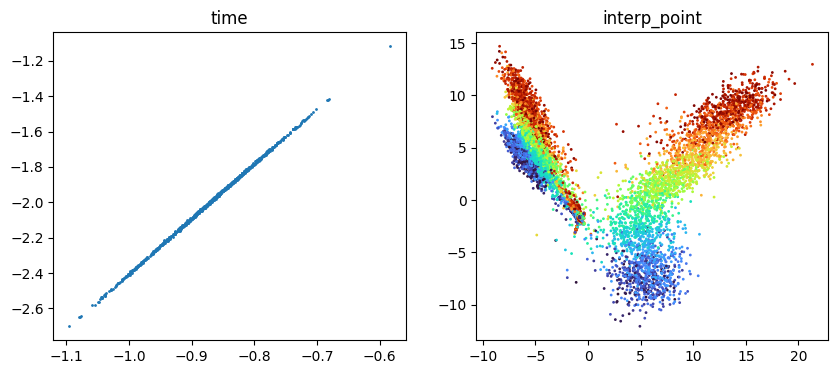

train acc: 0.567 | valid acc: 0.367 | invalid acc: 0.338


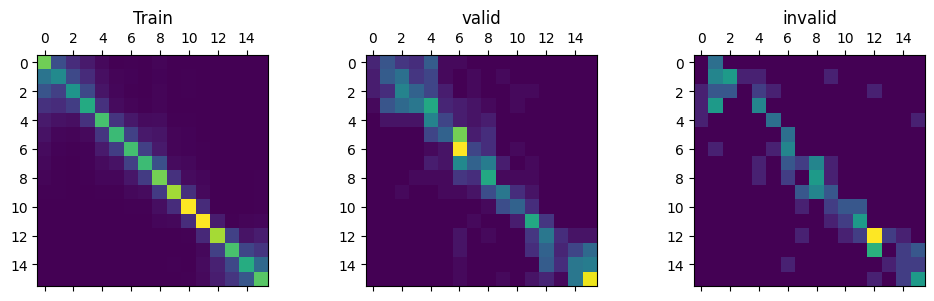

B1597 BG 11261


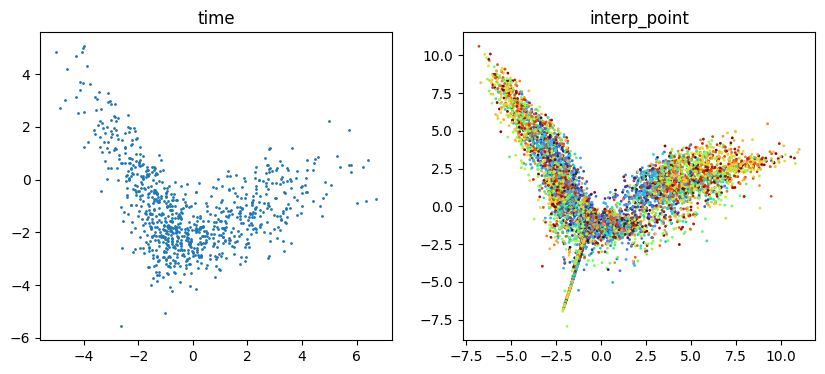

train acc: 0.442 | valid acc: 0.282 | invalid acc: 0.236


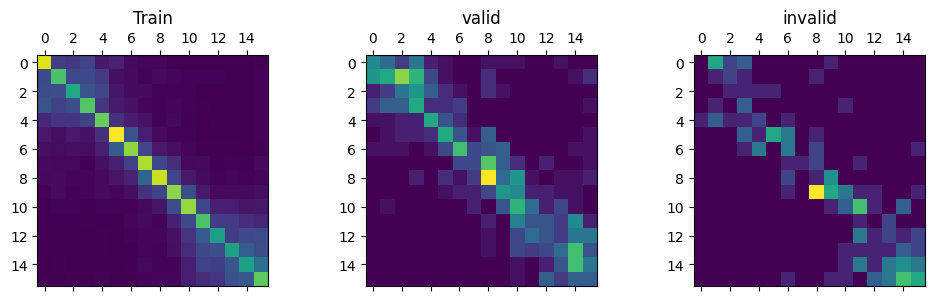

B1597 DF 2891
Skipping for not enough invalid trials (cue invalid)
B1597 AH 2965
Skipping for not enough invalid trials (cue invalid)
B1597 DH 2903
Skipping for not enough invalid trials (cue invalid)
B1597 DE 2892
Skipping for not enough invalid trials (cue invalid)
B1597 BH 2925
Skipping for not enough invalid trials (cue invalid)
B1595
B1595 BF 5529
Skipping for not enough invalid trials (cue invalid)
B1595 CG 4810
Skipping for not enough invalid trials (cue invalid)
B1595 AE 6044
Skipping for not enough invalid trials (cue invalid)
B1595 BE 280
B1595 AF 371
B1426
B1426 BE 829
Skipping for not enough invalid trials (cue invalid)
B1426 AE 1944
Skipping for not enough invalid trials (cue invalid)
B1426 CG 735
Skipping for not enough invalid trials (cue invalid)
B1426 AF 770
Skipping for not enough invalid trials (cue invalid)
B1426 AG 785
Skipping for not enough invalid trials (cue invalid)
B1426 CF 717
Skipping for not enough invalid trials (cue invalid)
B1426 BF 1911
Skipping for no

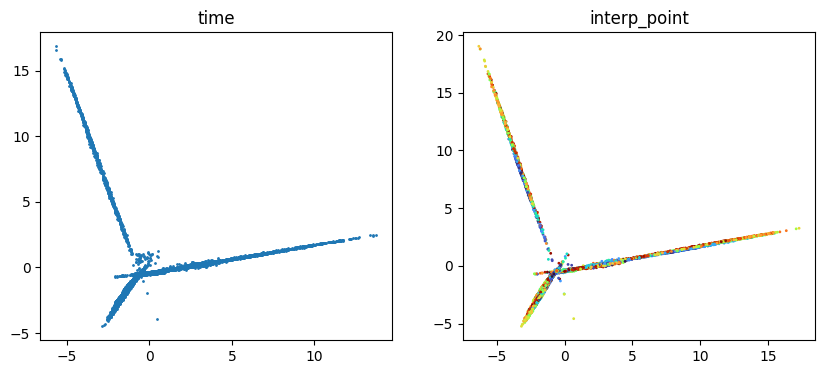

train acc: 0.73 | valid acc: 0.386 | invalid acc: 0.401


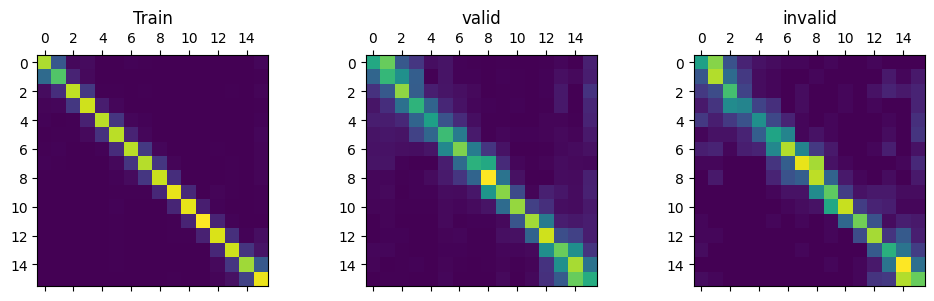

B1432 AE 40562


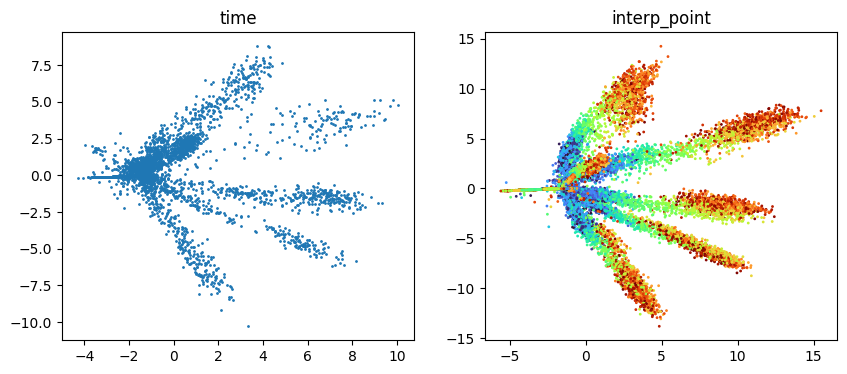

train acc: 0.639 | valid acc: 0.431 | invalid acc: 0.446


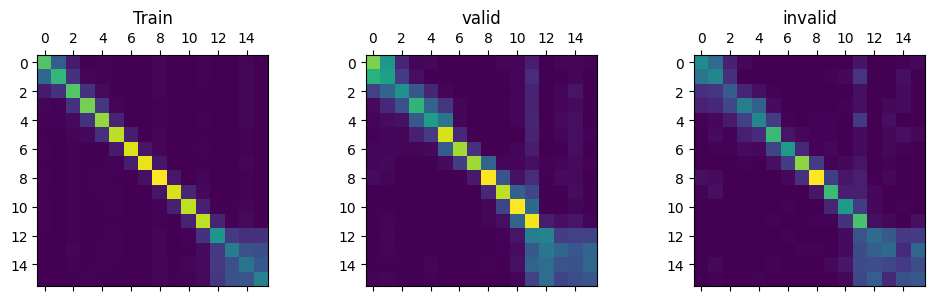

B1432 BF 40763


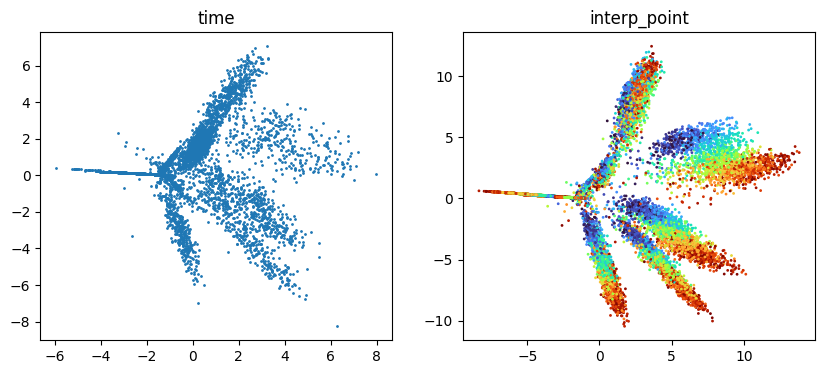

train acc: 0.642 | valid acc: 0.421 | invalid acc: 0.438


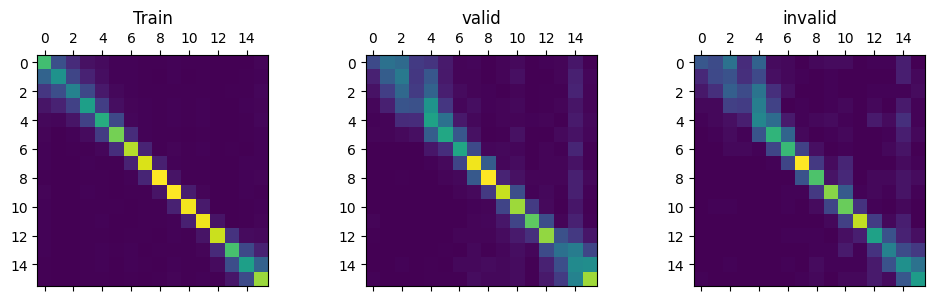

B1432 BE 20858


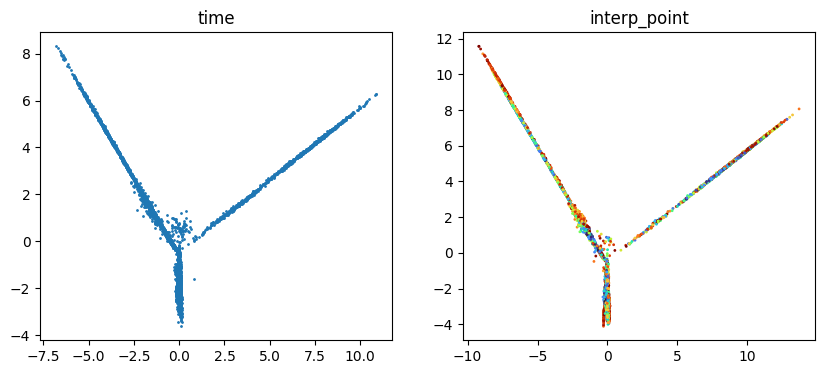

train acc: 0.528 | valid acc: 0.275 | invalid acc: 0.273


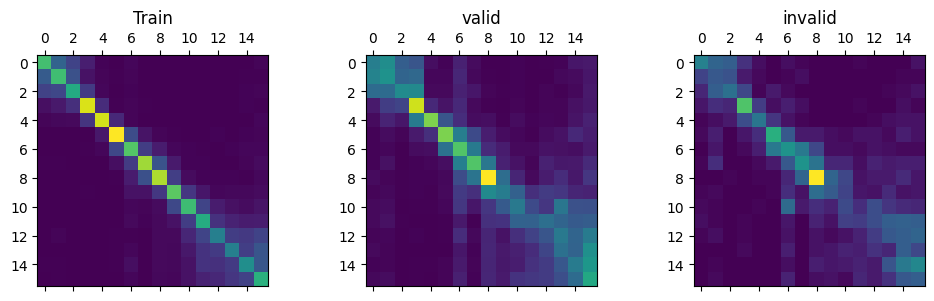

B1432 CG 29701


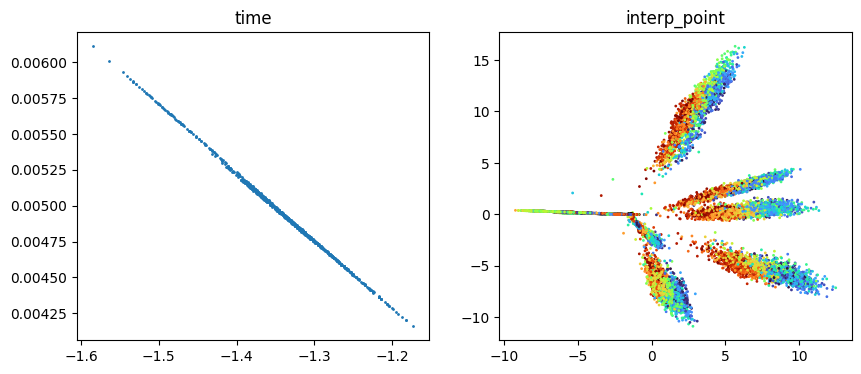

train acc: 0.613 | valid acc: 0.236 | invalid acc: 0.234


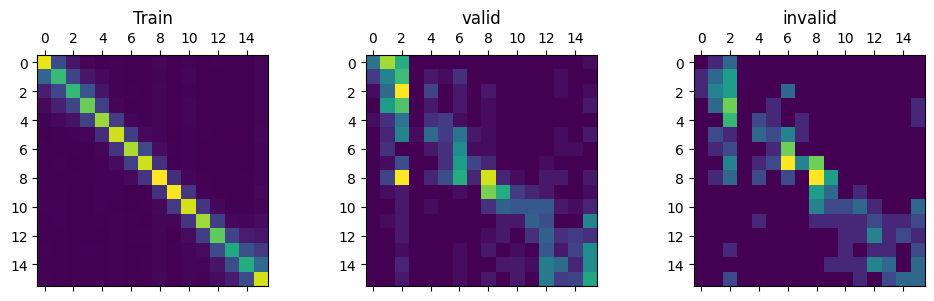

B1432 BG 9443
Skipping for not enough invalid trials (cue valid)
B1432 AG 9265


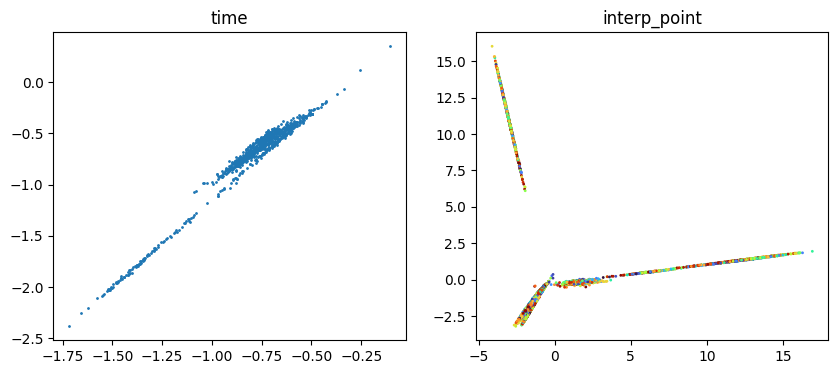

train acc: 0.752 | valid acc: 0.368 | invalid acc: 0.469


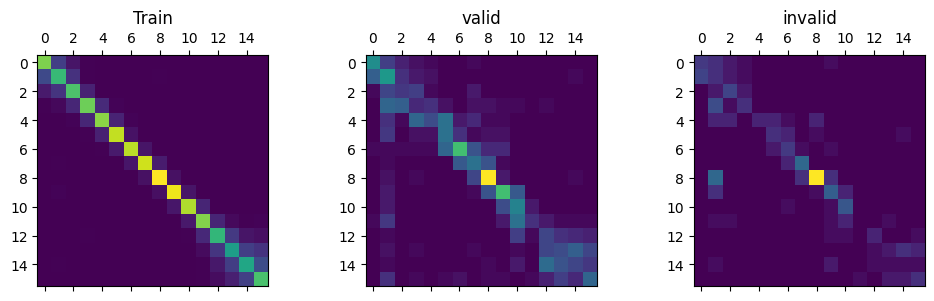

B1432 CF 9247


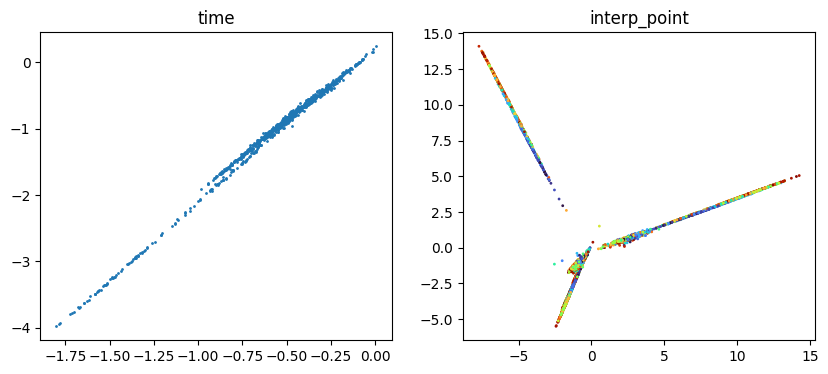

train acc: 0.75 | valid acc: 0.369 | invalid acc: 0.371


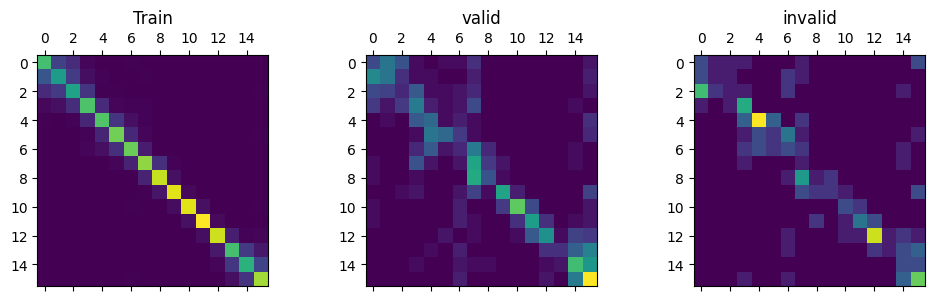

B1432 CE 9309


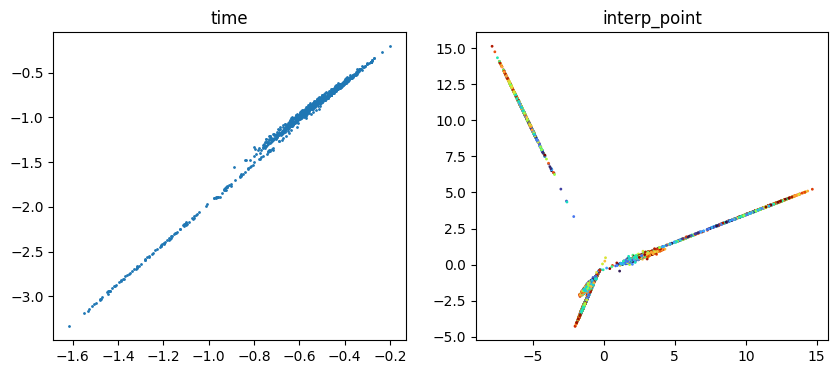

train acc: 0.568 | valid acc: 0.215 | invalid acc: 0.255


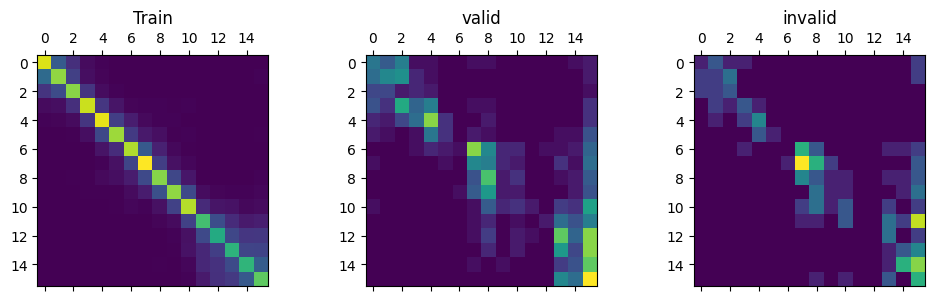

B1170
B1170 AF 11352


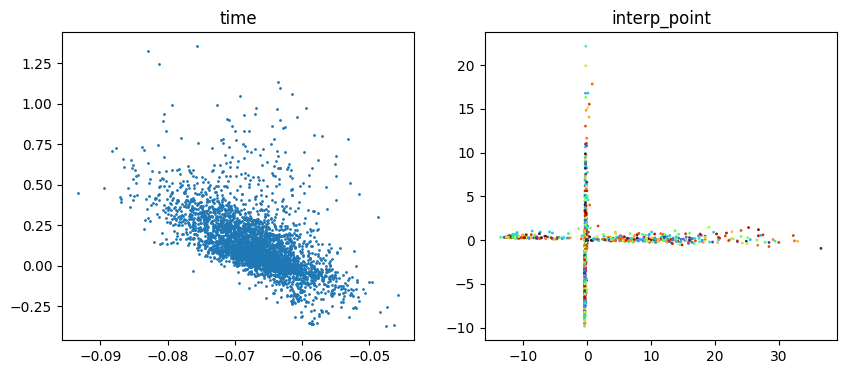

train acc: 0.361 | valid acc: 0.184 | invalid acc: 0.154


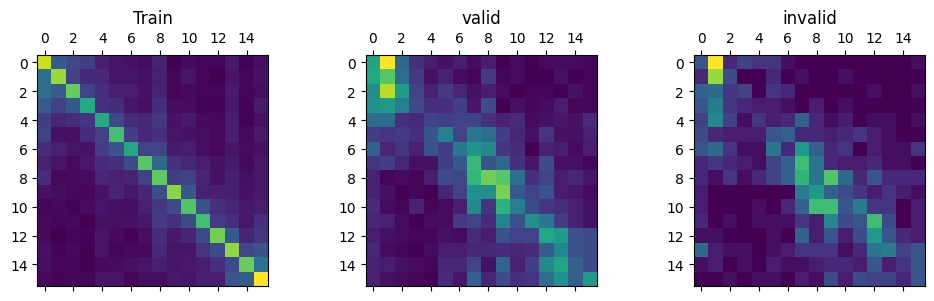

B1170 BE 11194


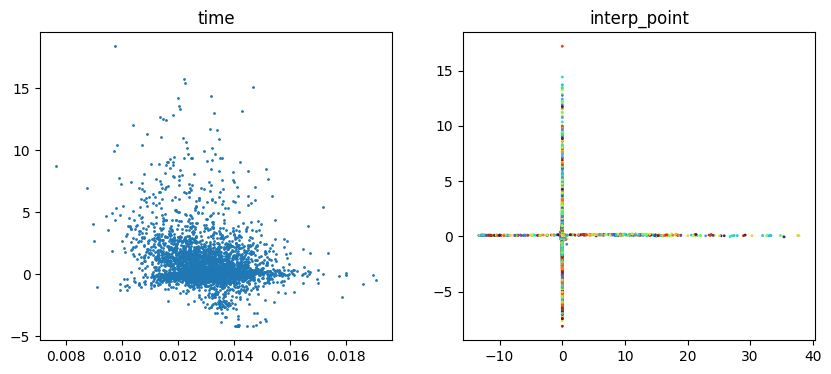

train acc: 0.307 | valid acc: 0.136 | invalid acc: 0.126


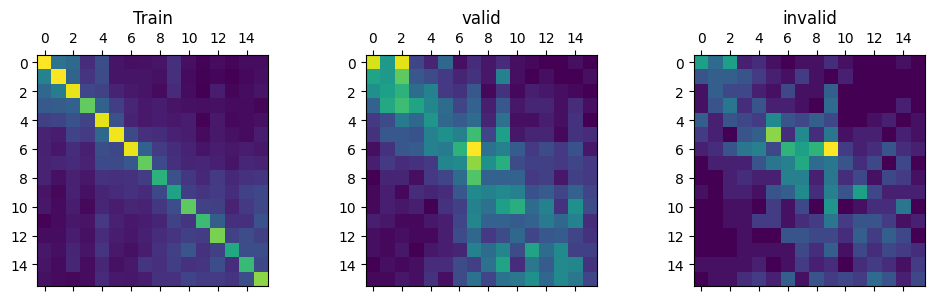

B1170 AE 34512


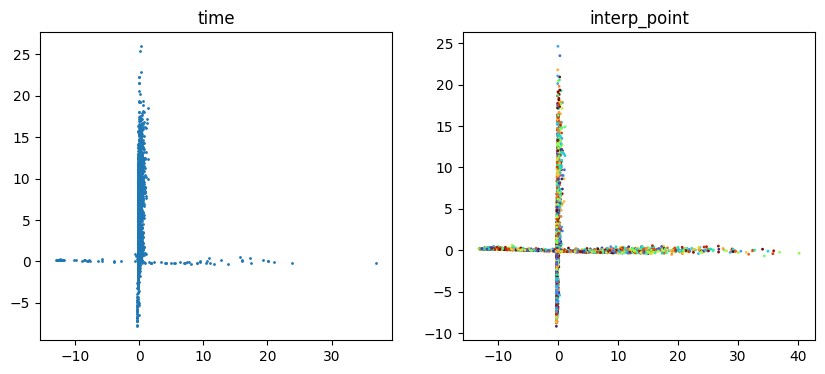

train acc: 0.309 | valid acc: 0.236 | invalid acc: 0.227


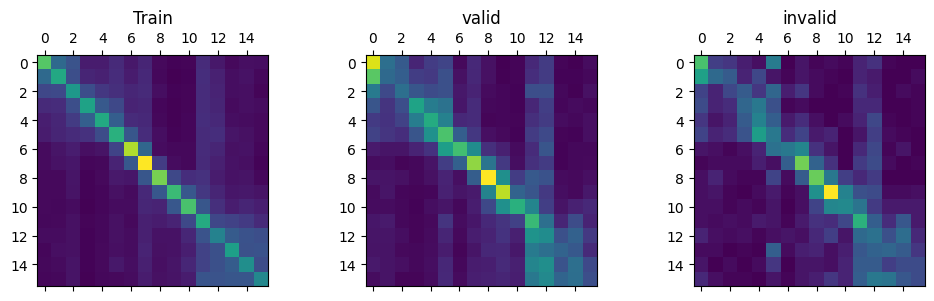

B1170 BF 24571


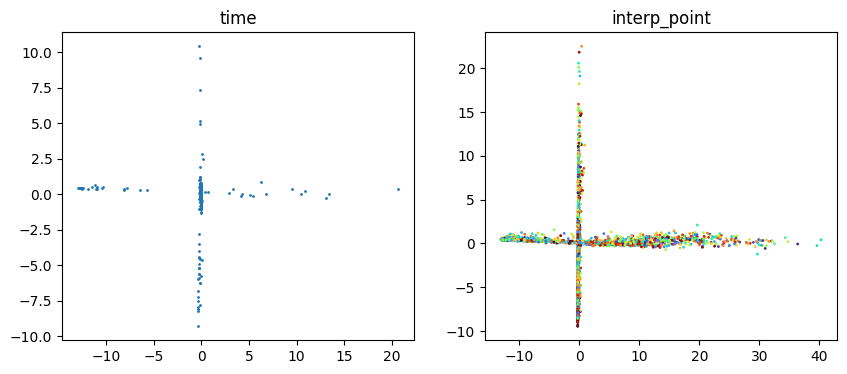

train acc: 0.282 | valid acc: 0.189 | invalid acc: 0.184


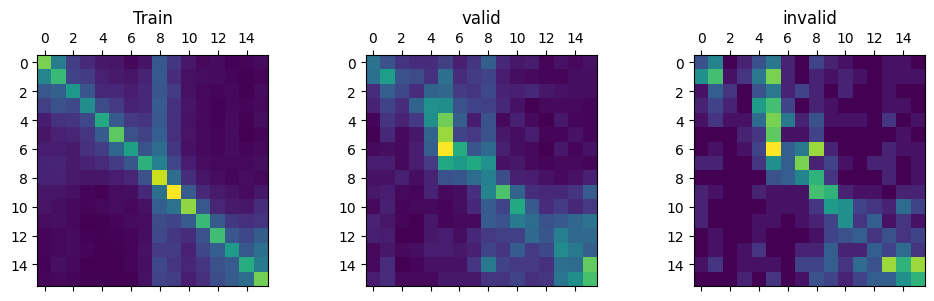

B1170 CE 6245
Skipping for not enough invalid trials (cue invalid)
B1170 CG 7623
Skipping for not enough invalid trials (cue invalid)
B1170 CF 6255
Skipping for not enough invalid trials (cue invalid)
B1170 BG 6340
Skipping for not enough invalid trials (cue invalid)
B1170 AG 6491
Skipping for not enough invalid trials (cue invalid)
B1244
B1244 AF 1017
Skipping for not enough invalid trials (cue invalid)
B1244 AE 2091


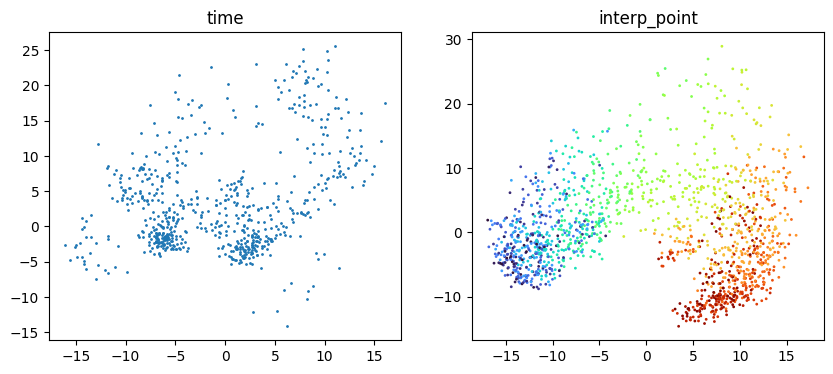

train acc: 0.999 | valid acc: 0.59 | invalid acc: 0.556


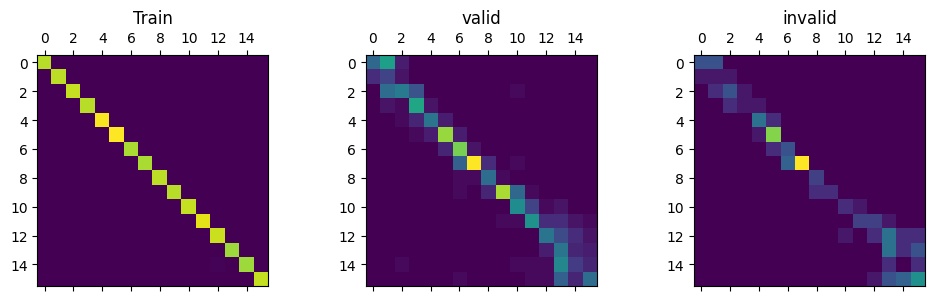

B1244 BE 1142
Skipping for not enough invalid trials (cue valid)
B1244 BF 1963
Skipping for not enough invalid trials (cue invalid)
B1244 AG 435
Skipping for not enough invalid trials (cue invalid)
B1244 BG 442
Skipping for not enough invalid trials (cue invalid)
B1244 CE 442
Skipping for not enough invalid trials (cue invalid)
B1244 CG 446
Skipping for not enough invalid trials (cue invalid)
B1244 CF 444
Skipping for not enough invalid trials (cue invalid)
B1593
B1593 AF 44767


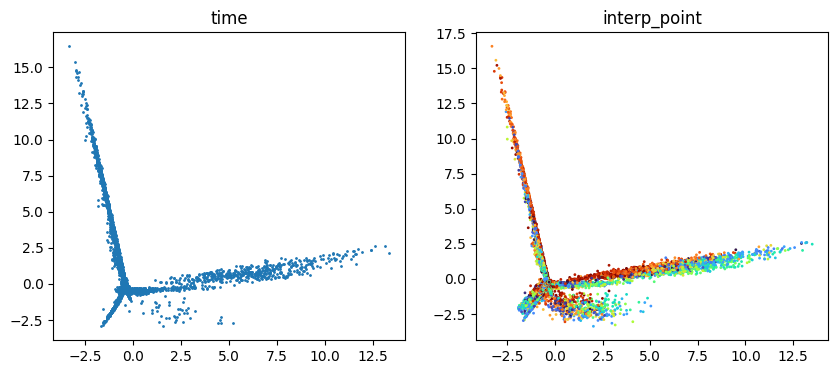

train acc: 0.346 | valid acc: 0.185 | invalid acc: 0.193


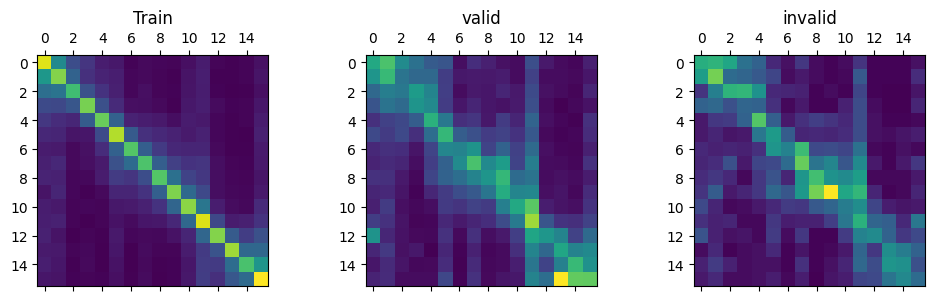

B1593 BE 47727


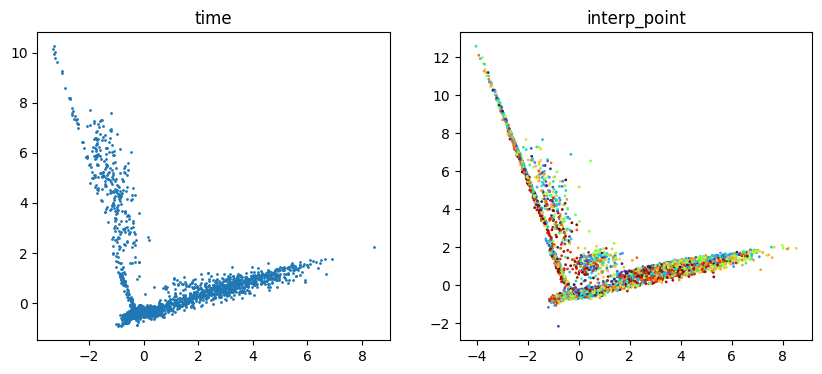

train acc: 0.231 | valid acc: 0.127 | invalid acc: 0.131


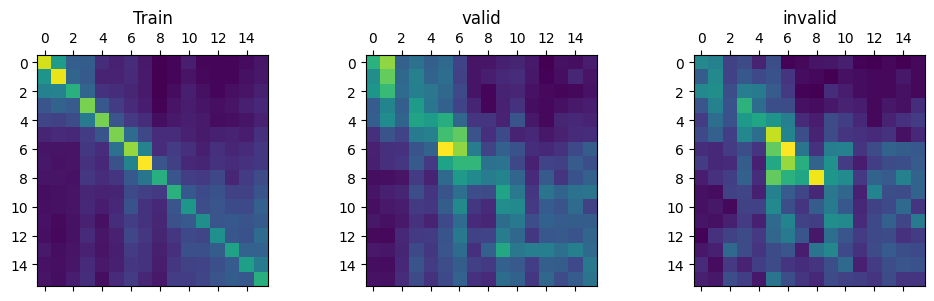

B1593 AE 93035


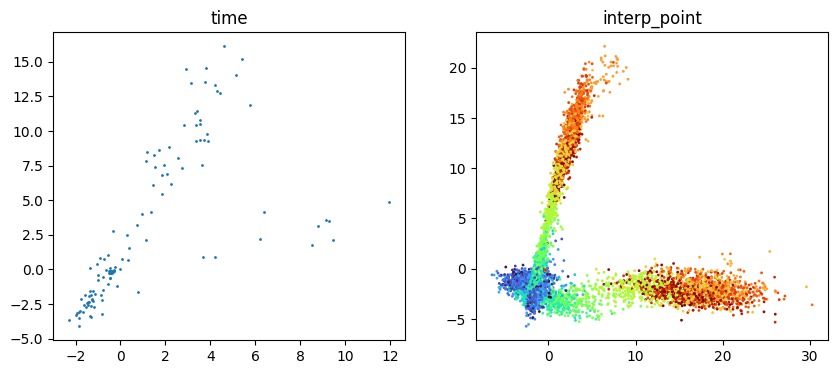

train acc: 0.335 | valid acc: 0.203 | invalid acc: 0.194


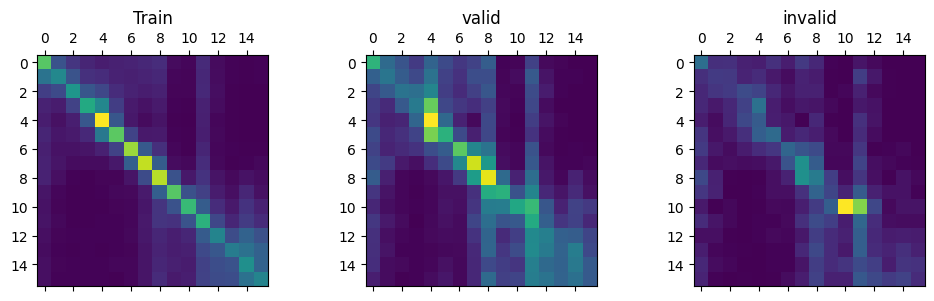

B1593 BF 85019


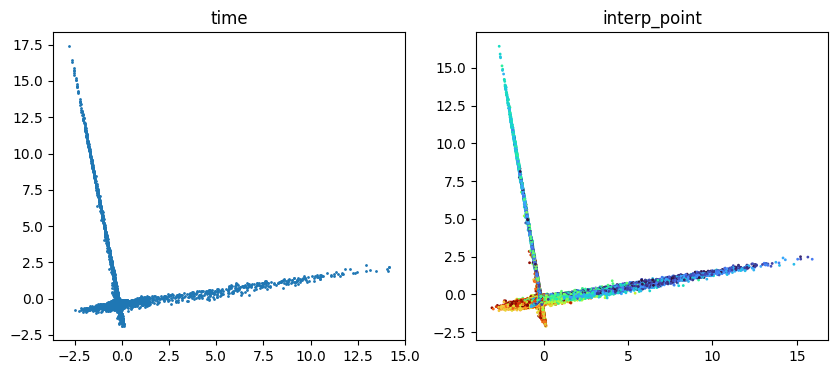

train acc: 0.305 | valid acc: 0.204 | invalid acc: 0.205


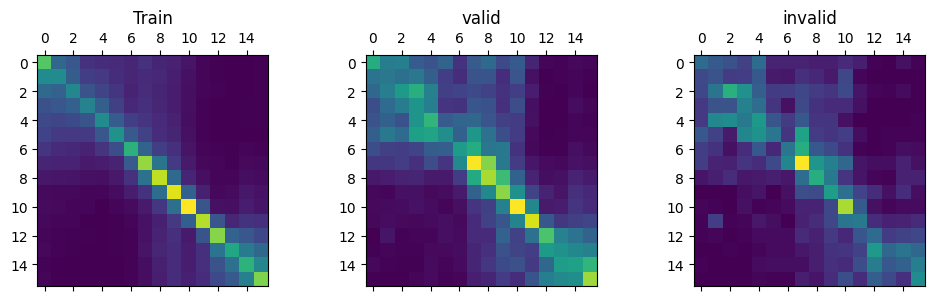

B1593 DG 19804
Skipping for not enough invalid trials (cue invalid)
B1593 BG 19778
Skipping for not enough invalid trials (cue invalid)
B1593 CG 19949
Skipping for not enough invalid trials (cue invalid)
B1593 CE 19781
Skipping for not enough invalid trials (cue invalid)
B1593 CF 28400
Skipping for not enough invalid trials (cue invalid)
B1593 AG 19876
Skipping for not enough invalid trials (cue invalid)
B1593 DF 19692
Skipping for not enough invalid trials (cue invalid)
B1593 DE 19887
Skipping for not enough invalid trials (cue invalid)
B1593 BH 12623
Skipping for not enough invalid trials (cue invalid)
B1593 AH 12450
Skipping for not enough invalid trials (cue invalid)
B1593 CH 12344
Skipping for not enough invalid trials (cue invalid)
B1593 DH 12238
Skipping for not enough invalid trials (cue invalid)
B1248
B1248 AE 93536


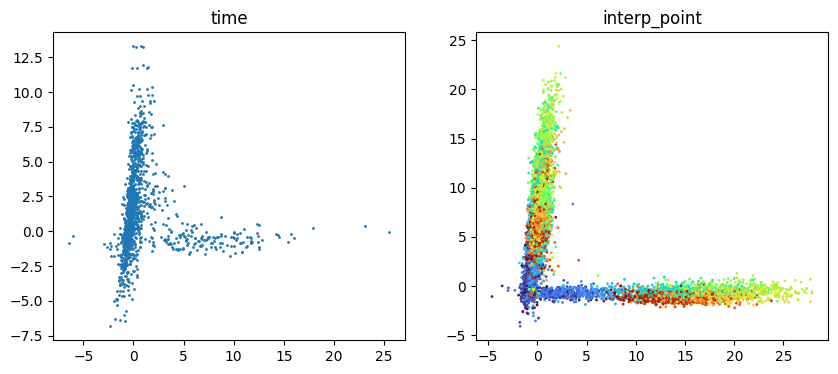

train acc: 0.322 | valid acc: 0.272 | invalid acc: 0.243


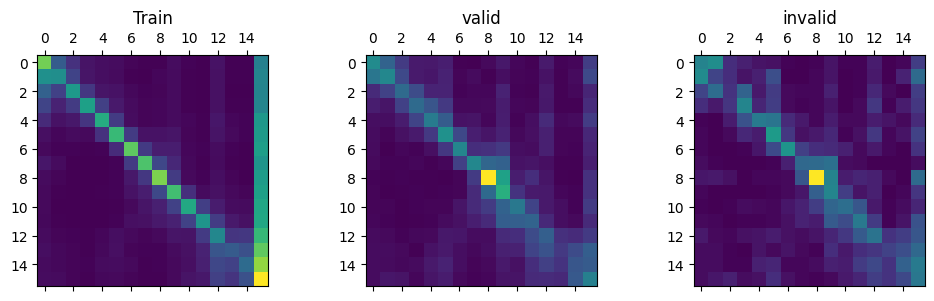

B1248 AF 24546


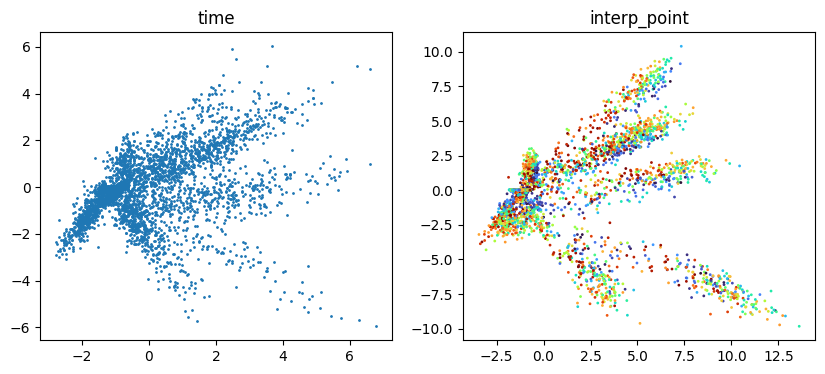

train acc: 0.531 | valid acc: 0.275 | invalid acc: 0.238


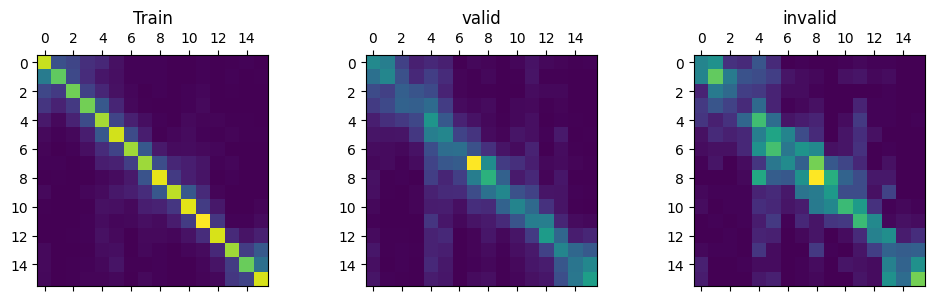

B1248 BF 36403


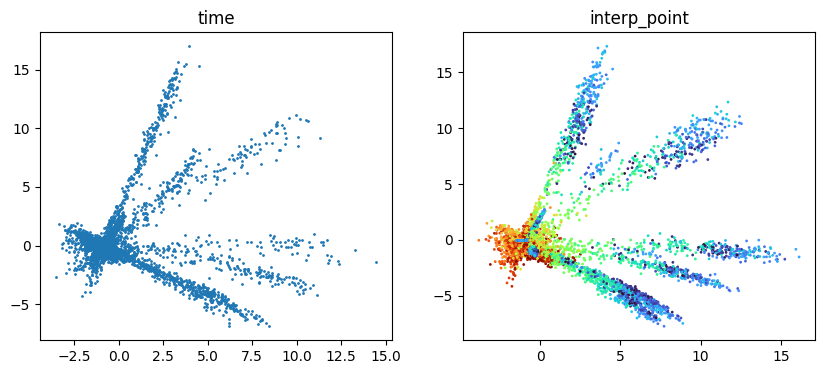

train acc: 0.504 | valid acc: 0.296 | invalid acc: 0.281


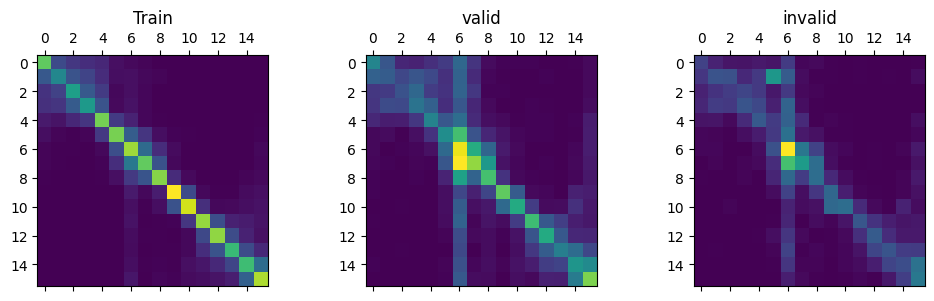

B1248 BE 66662


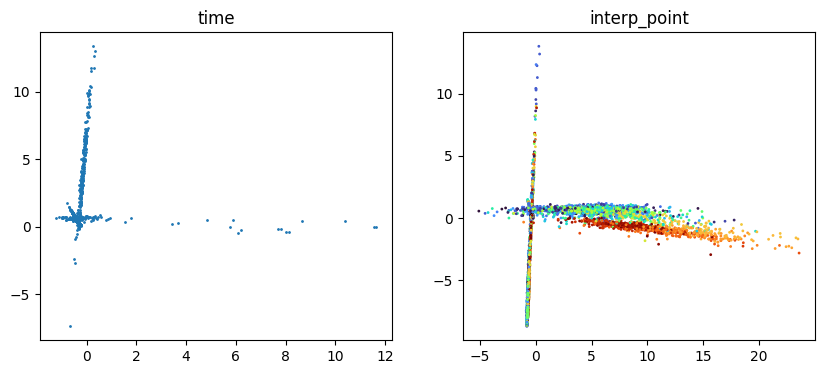

train acc: 0.205 | valid acc: 0.132 | invalid acc: 0.134


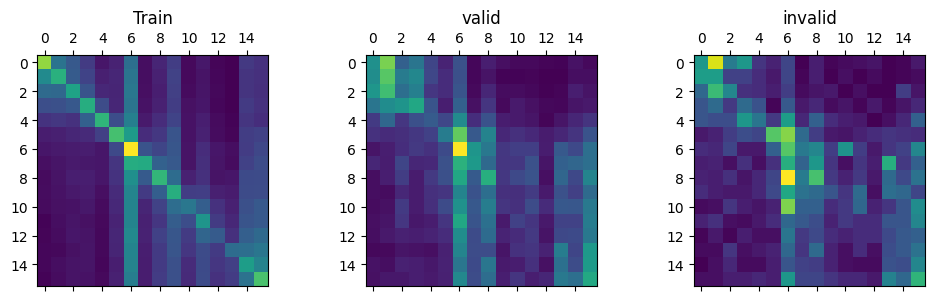

B1248 CH 6032
Skipping for not enough invalid trials (cue invalid)
B1248 AH 6012
Skipping for not enough invalid trials (cue invalid)
B1248 BG 6276
Skipping for not enough invalid trials (cue invalid)
B1248 DE 5946
Skipping for not enough invalid trials (cue invalid)
B1248 CF 22275
Skipping for not enough invalid trials (cue invalid)
B1248 DH 6073
Skipping for not enough invalid trials (cue invalid)
B1248 DG 6024
Skipping for not enough invalid trials (cue invalid)
B1248 DF 5948
Skipping for not enough invalid trials (cue invalid)
B1248 BH 5925
Skipping for not enough invalid trials (cue invalid)
B1248 AG 6188
Skipping for not enough invalid trials (cue invalid)
B1248 CE 6384
Skipping for not enough invalid trials (cue invalid)
B1248 CG 6155
Skipping for not enough invalid trials (cue invalid)


In [14]:
results_df = pd.DataFrame(
    columns=[
        "bird",
        "morph",
        "acc_train",
        "acc_held_out_valid",
        "acc_held_out_invalid",
        "n_train",
        "n_invalid",
        "cm_valid",
        "cm_invalid",
    ]
)

for bird, timestamp, sorter in tqdm(birds):
    print(bird)
    # get a dataframe of all trials
    response_df = pd.read_pickle(
        DATA_DIR / "population_analyses_with_passive2" / f"{bird}.pickle"
    )
    response_df["passive"] = [
        i[:3] == "exp" if type(i) == str else True for i in response_df.trial_id.values
    ]
    trial_df = response_df[
        ["cue", "interp", "interp_point", "trial_id", "interp_point_binned", "passive"]
    ]
    trial_df = trial_df.drop_duplicates()
    trial_df.index = trial_df.trial_id

    # determine which trials are valid
    # sort trials into cue valid and invalid
    trial_df["cue_valid"] = False
    trial_df.loc[
        trial_df.cue.isin(["CR1", "CR0"]) & (trial_df.interp_point_binned > 7),
        "cue_valid",
    ] = True
    trial_df.loc[
        trial_df.cue.isin(["CL1", "CL0"]) & (trial_df.interp_point_binned <= 7),
        "cue_valid",
    ] = True

    # load the population resonses and units present for each trial
    #spike_array = np.load(
    #    DATA_DIR / "population_analyses_with_passive2" / f"{bird}_spike_array.npy",
    #    mmap_mode="r",
    #)
    spike_array = np.memmap(
            DATA_DIR / "population_analyses_with_passive2" / f"{bird}_spike_array.dat",
            dtype=np.float32, mode='r')
    n_trials = len(trial_df)
    n_units = int(len(spike_array)/20 / n_trials)
    spike_array = spike_array.reshape((n_trials, n_units, 20))
    # units_present = np.load(DATA_DIR / 'population_analyses' / f"{bird}_units_present.npy")

    # plot the presence of units
    plot_unit_presence = False
    if plot_unit_presence:
        fig, ax = plt.subplots(figsize=(15, 4))
        ax.matshow((np.sum(np.abs(spike_array), axis=2) > 0).T, aspect="auto")
        ax.set_ylabel("Unit Number")
        ax.set_xlabel("Trial Number")
        plt.show()

    # reshape spike array
    spike_array = spike_array.reshape(
        (len(spike_array), np.product(spike_array.shape[1:]))
    )
    # set nans (units not present in dataset) to zero
    # spike_array[np.isnan(spike_array)] = 0

    # loop through interpolations to train model
    for interp in trial_df.interp.unique():
        print(bird, interp, np.sum(trial_df.interp == interp))

        # subset interpolation trials
        interp_trials = trial_df[trial_df.interp == interp].trial_id.values

        if len(interp_trials) < 256:
            continue

        m = trial_df.interp == interp

        spike_array_interp = spike_array[m]
            
        spike_array_interp[np.isnan(spike_array_interp)] = 0

        # get held out and passive data
        training_mask = (trial_df[m].cue.isin(["NC", "CN"])).values | (
            trial_df[m].passive == True
        ).values
        
        if len(spike_array_interp[training_mask]) < 256:
            continue

        # pca only on held out
        n_components = 256
        if spike_array_interp[training_mask].shape[1] <n_components:
            n_components = spike_array_interp[training_mask].shape[1] -1
        pca = PCA(n_components=n_components)
        spike_array_PCA = pca.fit_transform(spike_array_interp[training_mask])

        train_x = spike_array_PCA
        train_y = trial_df[m][training_mask].interp_point_binned.values

        trial_df_interp = trial_df[m]
        # subset into valid vs invalid, etc
        trial_df_interp = train_test_split_trials(trial_df_interp)

        if trial_df_interp is None:
            continue

        # get testing data
        signal = spike_array_interp
        held_out_valid_x = signal[
            trial_df_interp.data_category.isin(["training", "held_out_valid"])
        ]
        held_out_valid_y = trial_df_interp.interp_point_binned.values[
            trial_df_interp.data_category.isin(["training", "held_out_valid"])
        ]
        held_out_invalid_x = signal[
            trial_df_interp.data_category.values == "held_out_invalid"
        ]
        held_out_invalid_y = trial_df_interp.interp_point_binned.values[
            trial_df_interp.data_category.values == "held_out_invalid"
        ]
        # get PCs
        held_out_valid_x_pca = pca.transform(held_out_valid_x)
        held_out_invalid_x_pca = pca.transform(held_out_invalid_x)

        if plot_PCs:
            fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
            # trial_time = pd.to_datetime(trial_df[m][training_mask==False].trial_id.values)
            interp_bin = trial_df[m][training_mask].interp_point.values
            axs[0].scatter(
                np.vstack([held_out_valid_x_pca, held_out_invalid_x_pca])[:, 0],
                np.vstack([held_out_valid_x_pca, held_out_invalid_x_pca])[:, 1],
                # c=trial_time,
                s=1,
                cmap=plt.cm.viridis,
            )
            axs[0].set_title("time")
            axs[1].scatter(
                spike_array_PCA[:, 0],
                spike_array_PCA[:, 1],
                c=interp_bin,
                s=1,
                cmap=plt.cm.turbo,
            )
            axs[1].set_title("interp_point")
            plt.show()

        # Create an instance of the logistic regression classifier
        clf = linear_model.LogisticRegression(
            penalty="l2",
            class_weight="balanced",
            tol=0.01,
            n_jobs=15,
            solver="sag",
        )
        # fit model
        clf.fit(train_x, train_y)

        # get predictions and acc
        predictions_train = clf.predict(train_x)
        predictions_held_out_valid = clf.predict(held_out_valid_x_pca)
        predictions_held_out_invalid = clf.predict(held_out_invalid_x_pca)

        acc_held_out_valid = np.mean(predictions_held_out_valid == held_out_valid_y)
        acc_held_out_invalid = np.mean(
            predictions_held_out_invalid == held_out_invalid_y
        )
        acc_train = np.mean(predictions_train == train_y)

        cm_held_out_valid = confusion_matrix(
            held_out_valid_y, predictions_held_out_valid
        )
        cm_held_out_invalid = confusion_matrix(
            held_out_invalid_y, predictions_held_out_invalid
        )
        cm_train = confusion_matrix(train_y, predictions_train)

        print(
            f"train acc: {round(acc_train, 3)} "
            f"| valid acc: {round(acc_held_out_valid, 3)} "
            f"| invalid acc: {round(acc_held_out_invalid, 3)}"
        )

        if plot_confusion_matrix:
            fig, axs = plt.subplots(ncols=3, figsize=(12, 3))
            axs[0].matshow(cm_train)
            axs[0].set_title("Train")
            axs[1].matshow(cm_held_out_valid)
            axs[1].set_title("valid")
            axs[2].matshow(cm_held_out_invalid)
            axs[2].set_title("invalid")
            plt.show()

        results_df.loc[len(results_df)] = [
            bird,
            interp,
            acc_train,
            acc_held_out_valid,
            acc_held_out_invalid,
            len(train_x),
            len(held_out_invalid_y),
            cm_held_out_valid,
            cm_held_out_invalid,
        ]

        results_df.to_pickle(
            DATA_DIR
            / "population_analyses"
            / "classifier_results-uncued-passive.pickle"
        )

        # break
    # break

In [29]:
results_df[:3]

,bird,morph,acc_train,acc_held_out_valid,acc_held_out_invalid,n_train,n_invalid,cm_valid,cm_invalid
0,B1597,AF,0.547657,0.281187,0.273413,11929,1591,"[[103, 111, 55, 37, 10, 12, 3, 2, 0, 1, 2, 0, ...","[[26, 22, 12, 7, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0,..."
1,B1597,BE,0.399735,0.183005,0.164223,12078,1705,"[[74, 83, 46, 71, 14, 10, 1, 23, 3, 4, 1, 2, 3...","[[15, 6, 9, 12, 8, 4, 1, 8, 3, 0, 0, 0, 0, 0, ..."
2,B1597,AE,0.521908,0.346580,0.288967,38662,1713,"[[186, 112, 77, 2, 12, 6, 0, 1, 2, 3, 4, 0, 3,...","[[16, 19, 17, 2, 4, 2, 0, 1, 1, 1, 0, 0, 0, 0,..."


In [61]:
results_df.to_pickle(DATA_DIR / "population_analyses_with_passive2"/'results_df.pickle')

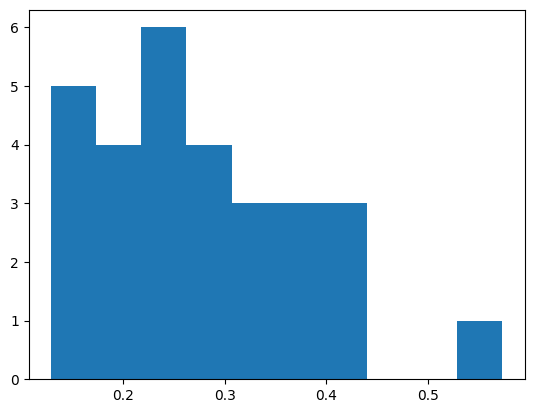

In [32]:
fig, ax = plt.subplots()
ax.hist((results_df.acc_held_out_valid.values + results_df.acc_held_out_invalid.values)/2);

### Acc. shift

In [15]:
cm_valid =  np.sum(np.stack(results_df.cm_valid.values), axis=0)
cm_invalid =  np.sum(np.stack(results_df.cm_invalid.values), axis=0)

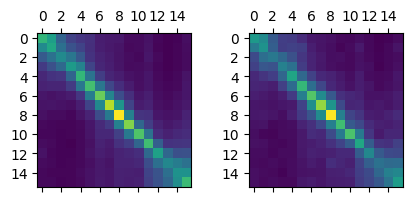

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(5,2))
axs[0].matshow(cm_valid)
axs[1].matshow(cm_invalid)

In [17]:
def confusion_matrix_to_labels(confusion_matrix):
    x_true = []
    x_predicted = []
    
    for true_label in range(len(confusion_matrix)):
        for predicted_label in range(len(confusion_matrix[true_label])):
            count = confusion_matrix[true_label][predicted_label]
            x_true.extend([true_label] * count)
            x_predicted.extend([predicted_label] * count)
            
    return np.array(x_true), np.array(x_predicted)

In [18]:
x_true, x_predicted = confusion_matrix_to_labels(cm_valid)
acc_curve_valid = np.array(
    [np.mean(np.abs(x_true - x_predicted) < i) for i in range(1, 17)]
)
acc_curve_sem_valid = np.array(
    [np.std(np.abs(x_true - x_predicted) < i)/np.sqrt(len(x_true)) for i in range(1, 17)]
)
x_true, x_predicted = confusion_matrix_to_labels(cm_invalid)
acc_curve_invalid = np.array(
    [np.mean(np.abs(x_true - x_predicted) < i) for i in range(1, 17)]
)
acc_curve_sem_invalid = np.array(
    [np.std(np.abs(x_true - x_predicted) < i)/np.sqrt(len(x_true)) for i in range(1, 17)]
)

(0.0, 15.0)

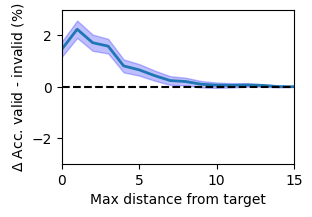

In [51]:
fig, ax = plt.subplots(figsize=(3,2))
ax.plot((acc_curve_valid - acc_curve_invalid)*100, lw=2)
m = (acc_curve_valid - acc_curve_invalid)*100
err = (acc_curve_sem_valid*3) * 100
ax.fill_between(np.arange(len(m)), m-err, m+err, color = 'blue', alpha = 0.25)
ax.axhline(0, color = 'k', ls='dashed')
ax.set_ylim([-3,3])
ax.set_ylabel('$\Delta$ Acc. valid - invalid (%)')
ax.set_xlabel('Max distance from target')
ax.set_xlim([0,15])

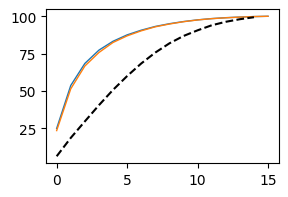

In [28]:
fig, ax = plt.subplots(figsize=(3,2))

ax.plot(acc_curve_valid*100, lw=1)
ax.plot(acc_curve_invalid*100, lw=1)
plt.plot(
    [
        np.mean(np.abs(np.random.permutation(x_true) - x_predicted) < i)*100
        for i in range(1, 16)
    ],
    color="black",
    ls='dashed'
)

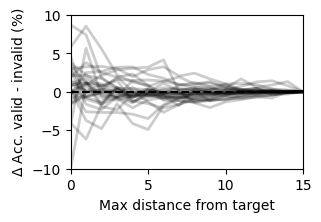

In [66]:
# look across morphs
fig, ax = plt.subplots(figsize=(3,2))

for cm_valid, cm_invalid in zip(results_df.cm_valid.values, results_df.cm_invalid.values):
    x_true, x_predicted = confusion_matrix_to_labels(cm_valid)
    acc_curve_valid = np.array(
        [np.mean(np.abs(x_true - x_predicted) < i) for i in range(1, 17)]
    )
    acc_curve_sem_valid = np.array(
        [np.std(np.abs(x_true - x_predicted) < i)/np.sqrt(len(x_true)) for i in range(1, 17)]
    )
    x_true, x_predicted = confusion_matrix_to_labels(cm_invalid)
    acc_curve_invalid = np.array(
        [np.mean(np.abs(x_true - x_predicted) < i) for i in range(1, 17)]
    )
    acc_curve_sem_invalid = np.array(
        [np.std(np.abs(x_true - x_predicted) < i)/np.sqrt(len(x_true)) for i in range(1, 17)]
    )
    
    ax.plot((acc_curve_valid - acc_curve_invalid)*100, lw=2, color = 'k', alpha = 0.2)
    #m = (acc_curve_valid - acc_curve_invalid)*100
    #err = (acc_curve_sem_valid*3) * 100
    #ax.fill_between(np.arange(len(m)), m-err, m+err, color = 'blue', alpha = 0.25)
ax.axhline(0, color = 'k', ls='dashed')
ax.set_ylim([-10,10])
ax.set_ylabel('$\Delta$ Acc. valid - invalid (%)')
ax.set_xlabel('Max distance from target')
ax.set_xlim([0,15])
plt.show()

### Neurometric shift

In [21]:
cm_valid =  np.sum(np.stack(results_df.cm_valid.values), axis=0)
cm_invalid =  np.sum(np.stack(results_df.cm_invalid.values), axis=0)

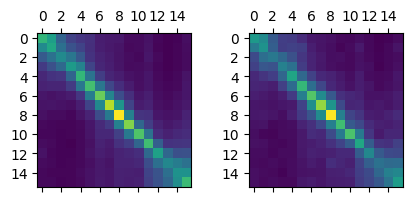

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(5,2))
axs[0].matshow(cm_valid)
axs[1].matshow(cm_invalid)

In [23]:
x_true_valid, x_predicted_valid = confusion_matrix_to_labels(cm_valid)
x_true_invalid, x_predicted_invalid = confusion_matrix_to_labels(cm_invalid)

In [37]:
cue_left_true = np.concatenate([x_true_valid[x_true_valid<8], x_true_invalid[x_true_invalid>=8]])
cue_left_pred = np.concatenate([x_predicted_valid[x_true_valid<8], x_predicted_invalid[x_true_invalid>=8]])

cue_right_true = np.concatenate([x_true_valid[x_true_valid>=8], x_true_invalid[x_true_invalid<8]])
cue_right_pred = np.concatenate([x_predicted_valid[x_true_valid>=8], x_predicted_invalid[x_true_invalid<8]])

In [38]:
len(cue_right_true), len(cue_left_true)

(122843, 124149)

In [48]:
cue_right_nm = np.array(
    [
        np.mean(cue_right_pred[cue_right_true == i] > 8)
        for i in np.unique(cue_right_true)
    ]
)
cue_left_nm = np.array(
    [np.mean(cue_left_pred[cue_left_true == i] > 8) for i in np.unique(cue_left_true)]
)

cue_right_nm_sem = np.array(
    [
        np.std(cue_right_pred[cue_right_true == i] > 8)
        / np.sqrt(np.sum(cue_right_true == i))
        for i in np.unique(cue_right_true)
    ]
)
cue_left_nm_sem = np.array(
    [
        np.std(cue_left_pred[cue_left_true == i] > 8)
        / np.sqrt(np.sum(cue_right_true == i))
        for i in np.unique(cue_left_true)
    ]
)

(0.0, 1.0)

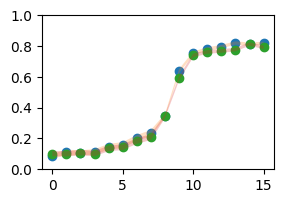

In [59]:
fig, ax = plt.subplots(figsize=(3,2))
ax.scatter(np.arange(16), cue_right_nm)
ax.fill_between(np.arange(16), cue_right_nm-cue_right_nm_sem*3, cue_right_nm+cue_right_nm_sem*3, alpha = 0.25)
ax.scatter(np.arange(16), cue_left_nm)
ax.fill_between(np.arange(16), cue_left_nm-cue_left_nm_sem*3, cue_left_nm+cue_left_nm_sem*3, alpha = 0.25)
ax.set_ylim([0,1])